In [3]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
%matplotlib inline
from scipy.optimize import curve_fit
import straxbra
from pymongo import MongoClient
import os
import strax
import json
import patrick_stylez as ps

Using TensorFlow backend.


In [4]:
ctx = straxbra.XebraContext(register=[straxbra.plugins.DAQReader],
                            config={'do_breaks' : False})
all_gains = {}

In [43]:
def gaus(x, h, mu, sigma):

    gaus = h * np.exp(-(x-mu)**2         /(2*sigma**2))
    return gaus
    

def fit_fcn(x, h_bgd, mu_bgd, sigma_bgd,h_uae, mu_uae, sigma_uae, h_spe, mu_spe, sigma_spe, h_dpe):
        background =    h_bgd             * np.exp(-(x - mu_bgd) ** 2        / (2 * sigma_bgd ** 2))
        uae =           h_uae             * np.exp(-(x - mu_uae) ** 2        / (2 * sigma_uae ** 2))
        spe =           h_spe             * np.exp(-(x - mu_spe) ** 2        / (2 * sigma_spe ** 2))
        dpe =           h_dpe             * np.exp(-(x - 2 * mu_spe) ** 2    / (2 * 2 * sigma_spe ** 2))
        fit_function = background + uae + spe + dpe
        return fit_function
    
def fit_fcn2(x, h_bgd, mu_bgd, sigma_bgd,h_uae, mu_uae, sigma_uae, h_spe, mu_spe, sigma_spe, h_dpe, h_tpe, h_qpe):
        background =    h_bgd             * np.exp(-(x - mu_bgd) ** 2        / (2 * sigma_bgd ** 2))
        uae =           h_uae             * np.exp(-(x - mu_uae) ** 2        / (2 * sigma_uae ** 2))
        spe =           h_spe             * np.exp(-(x - mu_spe) ** 2        / (2 * sigma_spe ** 2))
        dpe =           h_dpe             * np.exp(-(x - 2 * mu_spe) ** 2    / (2 * 2 * sigma_spe ** 2))
        tpe =           h_tpe             * np.exp(-(x - 3 * mu_spe) ** 2    / (3 * 2 * sigma_spe ** 2))
        qpe =           h_qpe             * np.exp(-(x - 4 * mu_spe) ** 2    / (4 * 2 * sigma_spe ** 2))
        fit_function_2 = background + uae + spe + dpe + tpe + qpe
        return fit_function_2
    
def fit_fcn3(x, h_bgd, mu_bgd, sigma_bgd,h_uae, mu_uae, sigma_uae, h_spe, mu_spe, sigma_spe):
        background =    h_bgd             * np.exp(-(x - mu_bgd) ** 2        / (2 * sigma_bgd ** 2))
        uae =           h_uae             * np.exp(-(x - mu_uae) ** 2        / (2 * sigma_uae ** 2))
        spe =           h_spe             * np.exp(-(x - mu_spe) ** 2        / (2 * sigma_spe ** 2))

        fit_function_3 = background + uae + spe
        return fit_function_3


def PlotForRun(context, run):
    fig, axs = plt.subplots(figsize=(18,12), nrows=3, ncols=3)
#     raw = ctx.get_array(run, 'raw_records')
    window_low = 40
    window_high = 60
    
    colors = ['red', 'green', 'cyan', 'magenta', 'lime', 'orange']
    
    gains = {
        'bin_centers' : [],
        'histogram' : [],
        'popt' : [],
        'pcov' : [],
        'adc_to_pe' : [],
        'gain' : [],
        'run' : int(run),
    }

    adc_to_e = (2.25/2**14) * (1e-8) * (1/50) * (1/1.602e-19) * 10
    adc_to_pe = (2.25/2**14) * (1e-8) * (1/50) * (1/1.602e-19) * (1/10)

    gain_list = []
    error_list = []
    gain_in_adc_counts = []
    for ch in range(8):
        if (ch==0 or ch==1 or ch == 6):
               bin_high =1250
        if (ch == 2 or ch == 4):
            bin_high = 1550
        if (ch == 3 or ch == 7):
            bin_high = 2150
        if ch == 5:
            bin_high = 950 
            
        num_bins = int((bin_high+100)/3)


        bins = np.linspace(-100,bin_high,num_bins)
        bin_widths = bins[1:] - bins[:-1]
        bin_centers = 0.5*(bins[1:] + bins[:-1])
        ax = axs[ch//3][ch%3]
        
        
        
        
        
        
        
        
        
        
        
        
        
        
        n, _ = np.histogram(raw['data'][raw['channel'] == ch,window_low:window_high].sum(axis=1), bins=bins)
#         n, _ = np.histogram(raw['data'][raw['channel'] == ch], bins=bins)

        
        
        
        
        
        
        
        
        
        
        
        
        
        
        
        
        
        
        
        
        
        
        sigma = np.maximum(np.ones_like(n), np.sqrt(n)/bin_widths)
        n = n/bin_widths
        gains['bin_centers'].append(bin_centers.tolist())
        gains['histogram'].append(n.tolist())
        cts = n.sum()
        
        
        mu_bkg_index = np.argmax(n)  
        mu_bkg = bin_centers[mu_bkg_index]
        h_bkg = n[mu_bkg_index]                            
        sigma_bkg = 0
        for i in n[mu_bkg_index:]:
            if i < h_bkg * 0.5:
                
                FWHM = np.abs(
                    bin_centers[np.where(n[mu_bkg_index:] ==i) + mu_bkg_index] - bin_centers[np.where(n[mu_bkg_index:] == h_bkg)+ mu_bkg_index])*2
                sigma_bkg +=FWHM / (2 * np.sqrt(2 * np.log(2)))
                #print(n[mu_bgd_index:].index(h_bgd))
                break
        
        if ch == 0:
            mu_spe_index = np.argmax(n[len(bins)//4 :]) + len(bins)//4 
        elif ch == 2:   
            
            valley = np.argmin(n[10:len(bins)//2])
            mu_spe_index = np.argmax(n[valley:len(bins)])+valley
            mu_spe = bin_centers[mu_spe_index]

        elif ch == 3:
            mu_spe_index = np.argmax(n[len(bins)//4 :]) + len(bins)//4 
        else:
            mu_spe_index = np.argmax(n[len(bins)//5 :]) + len(bins)//5
            
        mu_spe = bin_centers[mu_spe_index]
        print ('SPE_guess = %2.2f'%(mu_spe), 'for channel ', ch)

        h_spe = n[mu_spe_index]
#         sigma_spe = 0
#         for i in n[mu_spe_index:]:
#             if i < h_spe * 0.5:
#                 FWHM = np.abs(
#                     bin_centers[np.where(n[mu_spe_index:] ==i) + mu_spe_index] - bin_centers[np.where(n[mu_spe_index:]==h_spe)+ mu_spe_index])*2
#                 sigma_spe +=FWHM / (2 * np.sqrt(2 * np.log(2)))
#                 break
        
        
        
        
        
        mu_uae = mu_spe/2
        h_dpe = 0.1*h_spe
        h_tpe = 0.5*h_dpe
        h_qpe = 0.5*h_tpe
        
        if ch == 0:
            p0 = [h_bkg, mu_bkg, sigma_bkg,      100, mu_uae, 50,      h_spe, mu_spe, sigma_bkg,         h_dpe,  h_tpe, h_qpe ]
        else:
            p0 = [h_bkg, mu_bkg, sigma_bkg,       10, mu_uae, 50,      h_spe, mu_spe, sigma_bkg ]
        
       
    
    
    
    
        bounds_PMT0 = ((0, -50, 0.5*sigma_bkg,                    0, mu_bkg, 0.3*sigma_bkg,           mu_uae, mu_uae, 0.3*sigma_bkg,              0,         0,0), 
              (np.inf, np.inf, 1.5*sigma_bkg,                 h_spe, mu_spe, 2*sigma_bkg,       np.inf, np.inf, 4*sigma_bkg,    h_spe, h_dpe, np.inf))
        
      
        
        bounds_PMT_top = ((0, -50, 0,                    0, 0.3*mu_uae, 0,             0, 0.5*mu_spe , 0), 
              (       np.inf, np.inf, np.inf,             np.inf,1.2*mu_uae, 3*sigma_bkg,       np.inf, 1.5*mu_spe, np.inf))
        
        bounds_PMT_top_ch5 = ((0, -50, 0,                    0, mu_bkg, 0,             0, 0.5*mu_spe , 0), 
              (       np.inf, np.inf, np.inf,             np.inf,mu_spe, 3*sigma_bkg,       np.inf, 1.5*mu_spe, np.inf))
        
        


        if ch == 0:
            try:
                popt, pcov = curve_fit(fit_fcn2, bin_centers, n, p0=p0,bounds =bounds_PMT0,sigma=sigma, maxfev = 10000)
                perr = np.sqrt(np.diag(pcov))
                print(popt[7])
                ax.plot(bin_centers, (gaus(bin_centers, popt[10], 3*popt[7], popt[8])), 'r--', label='tpe peak')
                ax.plot(bin_centers, (gaus(bin_centers, popt[11], 4*popt[7], popt[8])), 'c--', label='qpe peak')
                ax.plot(bin_centers, (fit_fcn2(bin_centers, *popt)), 'b-')
                ax.plot(bin_centers, (gaus(bin_centers, popt[9], 2*popt[7], popt[8])), 'k--', label='dpe peak')
                ax.plot(bin_centers, n, c='k', alpha = 0.5)
                ax.plot(bin_centers, (gaus(bin_centers, popt[0], popt[1], popt[2])), 'g--', label='bkg peak')
                ax.plot(bin_centers, (gaus(bin_centers, popt[3], popt[4], popt[5])), 'y--', label='uae peak')
                ax.plot(bin_centers, (gaus(bin_centers, popt[6], popt[7], popt[8])), 'm--', label='spe peak')
                gains['popt'].append(popt.tolist())
                gains['pcov'].append(pcov.tolist())
                gains['adc_to_pe'].append(1./popt[7])
                print(1./popt[7])
                gains['gain'].append(popt[7]*adc_to_e)
                print([popt[7]*adc_to_e])
                gain_in_adc_counts.append(popt[7])
                gain_list.append(popt[7]*adc_to_pe)
                error_list.append(perr[7]*adc_to_pe)
            except Exception as e:
                print('CH%i failed\n' % ch)
        elif ch == 5:
            try:
                popt, pcov = curve_fit(fit_fcn3, bin_centers, n, p0=p0,bounds =bounds_PMT_top_ch5,sigma=sigma, maxfev = 20000)
                perr = np.sqrt(np.diag(pcov))
                ax.plot(bin_centers, (fit_fcn3(bin_centers, *popt)), 'b-') 
                ax.plot(bin_centers, n, c='k', alpha = 0.5)
                ax.plot(bin_centers, (gaus(bin_centers, popt[0], popt[1], popt[2])), 'g--', label='bkg peak')
                ax.plot(bin_centers, (gaus(bin_centers, popt[3], popt[4], popt[5])), 'y--', label='uae peak')
                ax.plot(bin_centers, (gaus(bin_centers, popt[6], popt[7], popt[8])), 'm--', label='spe peak')
                gains['popt'].append(popt.tolist())
                gains['pcov'].append(pcov.tolist())
                gains['adc_to_pe'].append(1./popt[7])
                print(1./popt[7])
                gains['gain'].append(popt[7]*adc_to_e)
                print([popt[7]*adc_to_e])
                gain_in_adc_counts.append(popt[7])
                gain_list.append(popt[7]*adc_to_pe)
                error_list.append(perr[7]*adc_to_pe)                
            except Exception as e:
                print('CH%i failed\n' % ch)

        else:
            try:
                popt, pcov = curve_fit(fit_fcn3, bin_centers, n, p0=p0,bounds =bounds_PMT_top,sigma=sigma, maxfev = 20000)
                perr = np.sqrt(np.diag(pcov))
                ax.plot(bin_centers, (fit_fcn3(bin_centers, *popt)), 'b-')
                ax.plot(bin_centers, n, c='k', alpha = 0.5)
                ax.plot(bin_centers, (gaus(bin_centers, popt[0], popt[1], popt[2])), 'g--', label='bkg peak')
                ax.plot(bin_centers, (gaus(bin_centers, popt[3], popt[4], popt[5])), 'y--', label='uae peak')
                ax.plot(bin_centers, (gaus(bin_centers, popt[6], popt[7], popt[8])), 'm--', label='spe peak')
                gains['popt'].append(popt.tolist())
                gains['pcov'].append(pcov.tolist())
                gains['adc_to_pe'].append(1./popt[7])
                print(1./popt[7])
                gains['gain'].append(popt[7]*adc_to_e)
                print([popt[7]*adc_to_e])
                gain_in_adc_counts.append(popt[7])
                gain_list.append(popt[7]*adc_to_pe)
                error_list.append(perr[7]*adc_to_pe)
            except Exception as e:
                print('CH%i failed\n' % ch)



        ax.set_ylim([1,None])
        ax.legend()
        ax.set_yscale('log')

    plt.show()
    return gains

SPE_guess = 238.25 for channel  0
216.9809121271729
0.004608700323897146
[372007412.21768314]
SPE_guess = 547.94 for channel  1
0.0018185725641646753
[942756266.625678]
SPE_guess = 821.17 for channel  2
0.0013275997532381434
[1291406296.964139]
SPE_guess = 988.95 for channel  3
0.0008821186731961317
[1943582800.4499993]
SPE_guess = 806.15 for channel  4
0.0015366034801528252
[1115753480.533091]
SPE_guess = 250.50 for channel  5
0.004515288804880598
[379703437.64646804]
SPE_guess = 349.50 for channel  6
0.0027157591599255796
[631304390.49196]
SPE_guess = 829.74 for channel  7
0.0013409402654387197
[1278558579.653693]


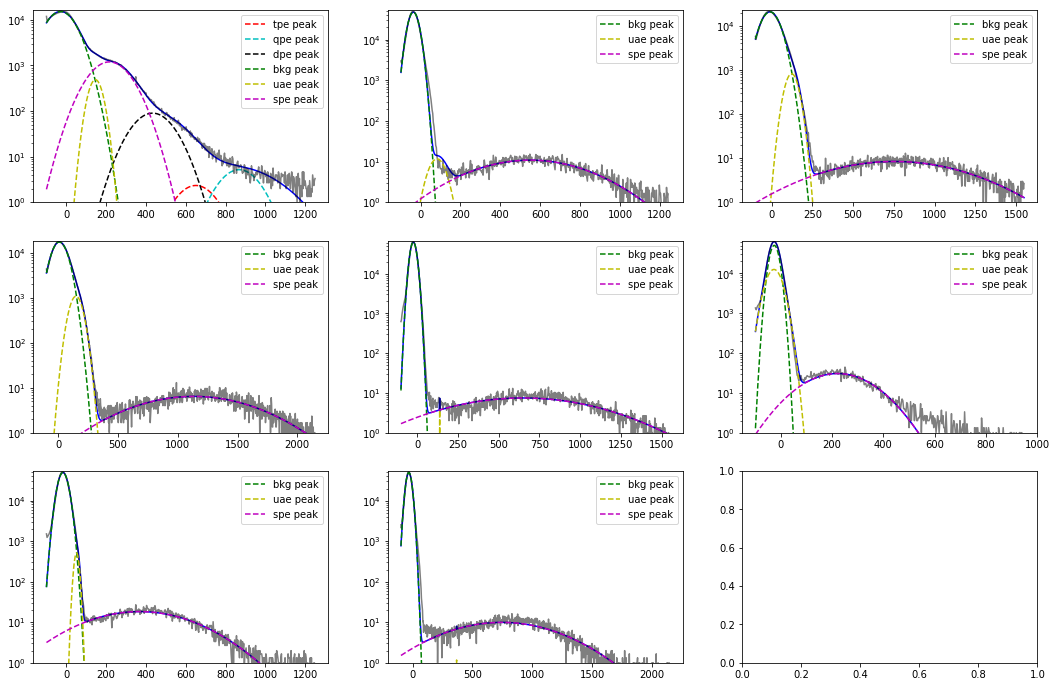

In [44]:
run = '00130'
raw = ctx.get_array(run, 'raw_records')
gaindoc = PlotForRun(ctx,run)

In [5]:
# with MongoClient(os.environ['MONGO_DAQ_URI']) as client:
#     client['xebra_daq']['pmt_gains'].update_one({'run' : 165},{'$set' : {gaindoc}})

In [28]:

# # gaindoc["run"] = 41
# with MongoClient(os.environ['MONGO_DAQ_URI']) as client:
#      client['xebra_daq']['pmt_gains'].insert_one(gaindoc)